In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

import pandas as pd
import os

from processing_funcs import *

In [ ]:
def lorentzian(f, f0, hwhm, snr):
    return snr / (1 + ((f - f0) / hwhm)**2)



def gen_spectrum(species='anolis', noise_floor=[], noise_amp=0.01, n_peaks=10, f0_dist='chi'):
    # Get frequency axis
    f = rfftfreq(32768, 1/44100)
    
    # Get num bins in the spectrum
    n_bins = len(noise_floor)
    if n_bins != 8192:
        raise ValueError(f"Expected noise floor to be 8192 bins, but it's {n_bins} bins!")
    
    # Initialize matrix to store all the different peaks to be added to the noisefloor
    spec_components = np.empty((n_peaks + 1, n_bins))
    
    # Add noise floor
    spec_components[-1, :] = noise_floor
    
    # Set generation parameters
    
    # f0: we'll draw half from a chi square
    f0_chi_dof = 10
    f0_chi_og_pivot = 20 # This is the value of the original distribution that we want to "grab"
    f0_chi_new_pivot = 8000 # We'll rescale ("pull") the distribution so that that value becomes this value
    # and the other half from a uniform distribution
    f0_min = 50
    f0_max = 6000
    
    # hwhm: we'll draw from uniform distribution
    if species == 'Anolis':
        hwhm_min = 25
        hwhm_max = 125
    elif species == 'Human':
        hwhm_min = 3
        hwhm_max = 15
    elif species == 'General':
        hwhm_min = 3
        hwhm_mx = 15

    # SNR: we'll draw from a uniform distribution
    snr_min = 0
    snr_max = 25
    
    # Create a Generator instance
    rng = np.random.default_rng()  # Default random generator instance
    
    # Generate and add peaks
    for i in range(n_peaks):
        # f0
        # Draw the positions from a chi square
        if f0_dist == 'chi':
            f0 = rng.chisquare(df=f0_chi_dof)*f0_chi_new_pivot/f0_chi_og_pivot
            # make sure it's below our spectral max, resample if not
            while f0 > f[-1]:
                f0 = rng.chisquare(df=f0_chi_dof)*f0_chi_new_pivot/f0_chi_og_pivot

        
        # hwhm
        hwhm = rng.uniform(hwhm_min, hwhm_max)
        
        # SNR
        snr = rng.uniform(snr_min, snr_max)
        
        # Add peak
        spec_components[i, :] = lorentzian(f, f0, hwhm, snr)
        

        
        

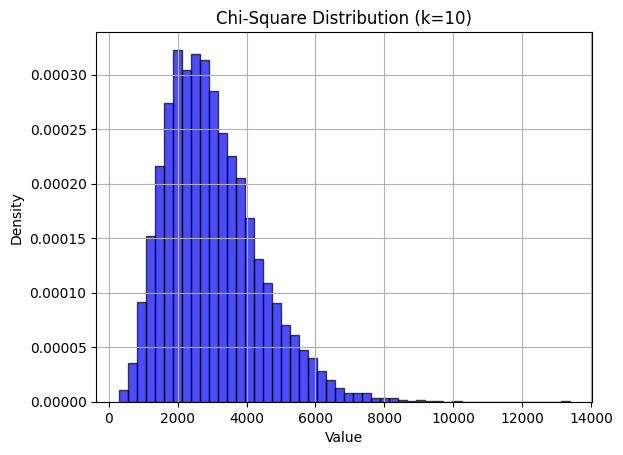

In [2]:
# VISUALIZE CHI SQUARE POSITION DIST
# Parameters for the chi-square distribution
f0_chi_dof = 10  # k (degrees of freedom)
num_samples = 10000     # Number of samples to generate

# Generate samples from a chi-square distribution
f0_chi_og_pivot = 20
f0_chi_new_pivot = 6000
chi_square_samples = np.random.chisquare(df=f0_chi_dof, size=num_samples)*f0_chi_new_pivot/f0_chi_og_pivot

# Plot the histogram of the samples
plt.hist(chi_square_samples, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Chi-Square Distribution (k={f0_chi_dof})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [25]:
# VISUALIZE LORENTZIAN
f = rfftfreq(32768, 1/44100)
print(np.diff(f))
# f0 = 5000
# snr = 1
# hwhm = 1000

# plt.plot(f, lorentzian(f, f0, hwhm, snr))
# plt.show()

[1.3458252 1.3458252 1.3458252 ... 1.3458252 1.3458252 1.3458252]


In [19]:
# VISUALIZE NOISE FLOOR
# Get frequency axis
f = rfftfreq(32768, 1/44100)[0:8192]

# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)

df = df[df['filepath'].str.contains("UWO Data")]
df = df[df['filepath'].str.contains("waveform")]
df = df.sample(frac=1).reset_index(drop=True)
spectrums = df['spectrum'].to_list()
filepaths = df['filepath'].to_list()
species = df['species'].to_list()

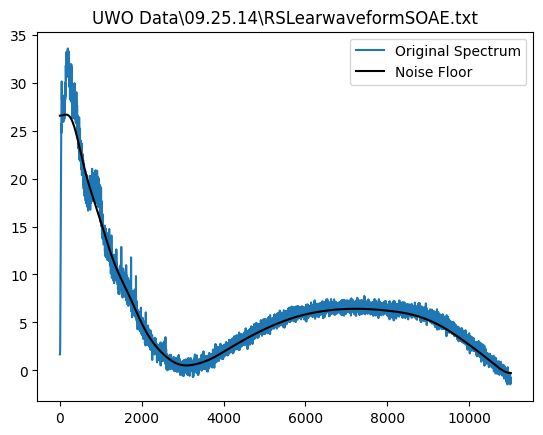

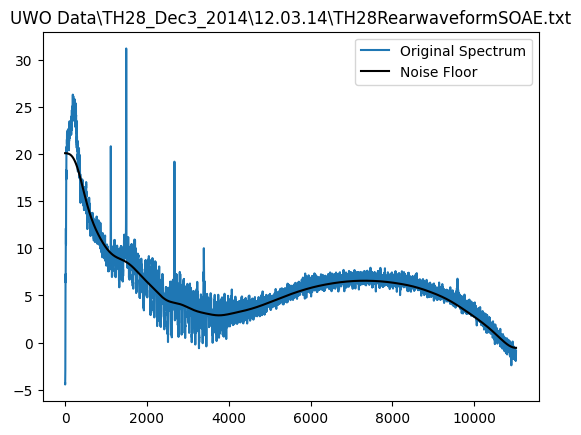

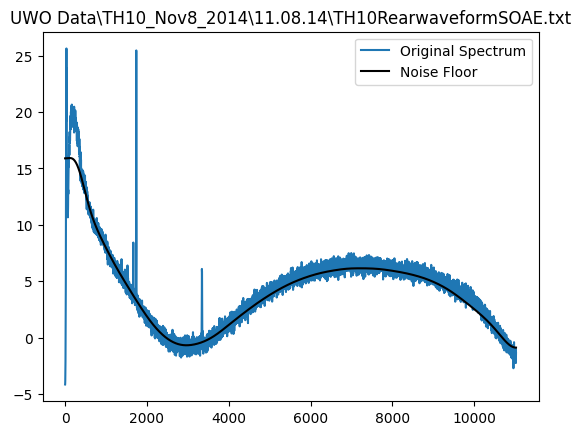

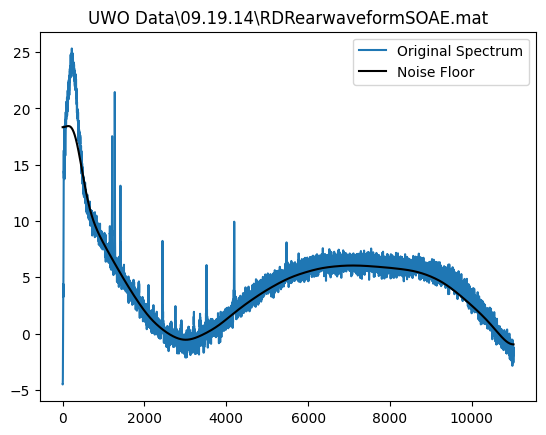

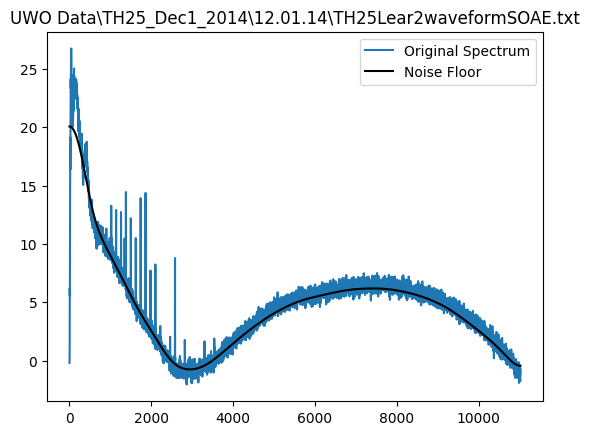

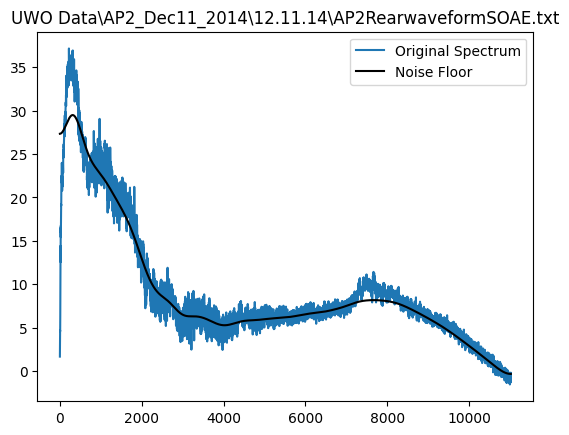

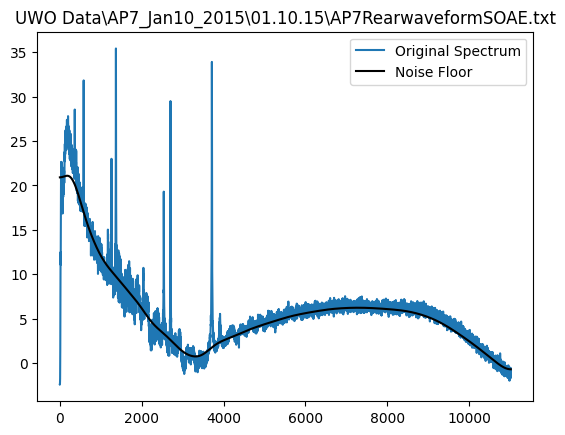

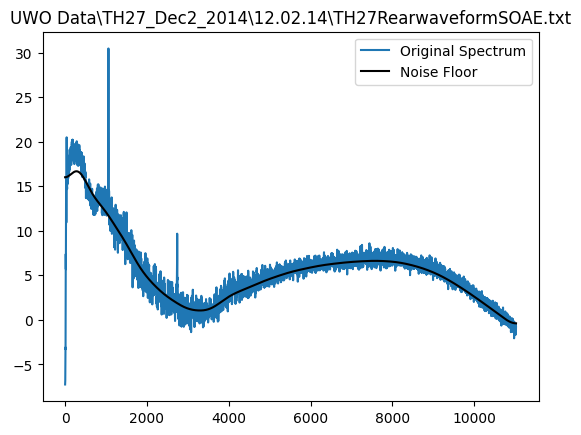

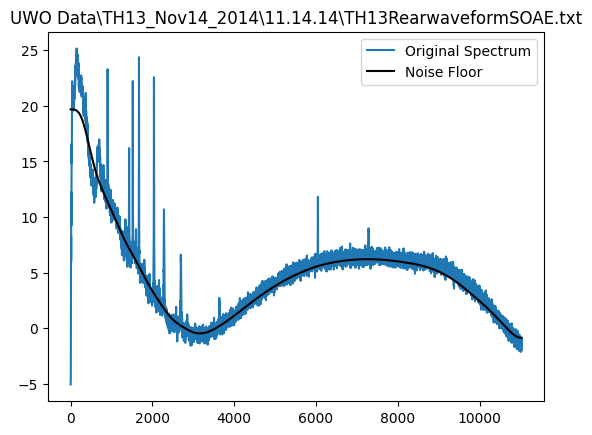

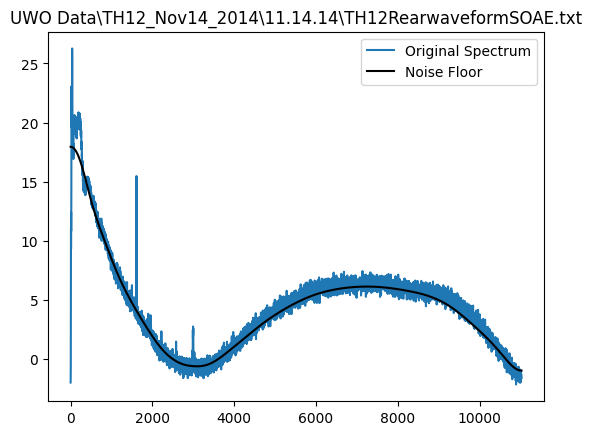

In [21]:
 # local-ness factor 
frac_broad= 0.3
smoothing_sigma = 150
fit_close_cutoff = 300

i = 0



for spectrum, filepath in zip(spectrums, filepaths):
    i+=1
    if i > 10:
        break
    
    
    noise_floor = get_noise_floor(f, spectrum)
    plt.plot(f, spectrum, label='Original Spectrum')
    # plt.plot(f, min_spectrum, 'black', label='min_spectrum')
    # plt.plot(f, fit_broad,'g--',label='Broad LOWESS Fit')
    # plt.plot(f, fit_close,'r--',label='Close LOWESS Fit')
    plt.plot(f, noise_floor,'black',label='Noise Floor')
    plt.legend()
    plt.title(filepath)
    plt.savefig(filepath + ".png")
    plt.show()
    


